**CORSICAN DATABASE**

In [ ]:
# 500 RGB AND GROUND TRUTH

Importing necessary modules/packages

In [ ]:
%matplotlib inline
import os
import copy
import torch
import random
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.13.1+cu116


Mounting google drive to access data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


path to images and groundtruth

In [ ]:
Datapath = '/content/gdrive/MyDrive/Minor_Project_Forest_Fire/Akash/CorsicanDB/training/rgb/'
Labelpath = '/content/gdrive/MyDrive/Minor_Project_Forest_Fire/Akash/CorsicanDB/training/gt/'

Function to create random patches from images

In [ ]:
def img_transfer(img, imgLabel, bh, bw, no_of_patch):
  
  h = img.shape[0]
  w = img.shape[1]
  c = img.shape[2]
  imgArr = np.empty((no_of_patch, bh*bw*3))
  labelArr = np.empty((no_of_patch, bh*bw*1))

  for i in range(no_of_patch):
    ih = random.randint(0, h-bh)
    iw = random.randint(0, w-bw)
    iArrI = img[ih: ih+bh, iw: iw+bw, :]
    iArrL = img[ih: ih+bh, iw: iw+bw, :]

    for ci in range(c):
      for bhi in range(bh):
        for bwi in range(bw):
          imgArr[i][ci*bh*bw + bhi*bw + bwi] = iArrI[bhi][bwi][ci]
          if ci==0:
            labelArr[i][ci*bh*bw + bhi*bw + bwi] = iArrL[bhi][bwi][ci]
  
  return imgArr, labelArr

In [ ]:
#patch size and number of patches required
patchH = 9
patchW = 9
PatchperImage = 1000

In [ ]:
#Tensor to hold the data
TrainImages = torch.DoubleTensor(400*PatchperImage, 3*patchH*patchW)
TrainLabels = torch.LongTensor(400*PatchperImage, patchH*patchW)

In [ ]:
#Read each training image and crop random patches
t_no = 0
for img_no in range(1, 401):
  imD = Image.open(Datapath +  str('{:03}_rgb.png'.format(img_no)))
  imD = imD.resize((256,256))
  imD = np.array(imD)

  imL = Image.open(Labelpath + str('{:03}_gt.png'.format(img_no)))
  imL = imL.resize((256,256))
  imL = np.array(imL)
  imL = np.reshape(imL, (imL.shape[0], imL.shape[1], 1))

  imD, imL = img_transfer(imD, imL, patchH, patchW, PatchperImage)
  imD = imD/255.0
  imL = imL/255.0

  for i in range(PatchperImage):
    TrainImages[t_no] = torch.from_numpy(imD[i])
    TrainLabels[t_no] = torch.from_numpy(imL[i])
    t_no = t_no + 1

In [ ]:
#Printing Training Image and Label size

print(TrainImages.size())
print(TrainLabels.size())

torch.Size([2000000, 243])
torch.Size([2000000, 81])


In [ ]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


**AUTOENCODER**

In [ ]:
class autoencoder(nn.Module):
  def __init__(self):
    super(autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(patchH*patchW*3, patchH*patchW), 
        nn.Tanh(),
        nn.Linear(patchH*patchW, patchH*patchW),
        nn.Tanh())
    
    self.decoder = nn.Sequential(
        nn.Linear(patchH*patchW, patchH*patchW),
        nn.Tanh(), 
        nn.Linear(patchH*patchW, patchH*patchW*3), 
        nn.Sigmoid())
  
  def forward(self, x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x

net = autoencoder()
print(net)

net = net.double().to(device)

init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=243, out_features=81, bias=True)
    (1): Tanh()
    (2): Linear(in_features=81, out_features=81, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=81, out_features=81, bias=True)
    (1): Tanh()
    (2): Linear(in_features=81, out_features=243, bias=True)
    (3): Sigmoid()
  )
)


Optimization Technique

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

TRAINING PHASE

At iteration: 1 / 1000 ; MSE Loss: 0.007755
At iteration: 101 / 1000 ; MSE Loss: 0.000488
At iteration: 201 / 1000 ; MSE Loss: 0.000433
At iteration: 301 / 1000 ; MSE Loss: 0.000403
At iteration: 401 / 1000 ; MSE Loss: 0.000388
At iteration: 501 / 1000 ; MSE Loss: 0.000376
At iteration: 601 / 1000 ; MSE Loss: 0.000392
At iteration: 701 / 1000 ; MSE Loss: 0.000370
At iteration: 801 / 1000 ; MSE Loss: 0.000364
At iteration: 901 / 1000 ; MSE Loss: 0.000364
Training finished


Text(0, 0.5, 'Training loss')

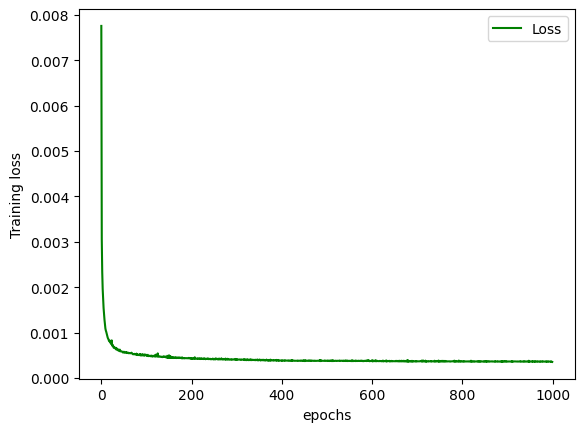

In [ ]:
iterations = 1000 #1000
Batchsize = 1000
trainLoss = []

for epoch in range(iterations):
  runningLoss = 0
  for i in range(int(TrainImages.size()[0]/Batchsize)):
    inputs = torch.index_select(TrainImages, 0, torch.linspace(i*Batchsize,(i+1)*Batchsize-1, steps=Batchsize).long()).double()

    inputs = inputs.to(device)

    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, inputs)
    loss.backward()
    optimizer.step()
    runningLoss +=loss.item()
  
  trainLoss.append(runningLoss/(TrainImages.size()[0]/Batchsize))
  if epoch%100 == 0:
    print('At iteration: %d / %d ; MSE Loss: %f'%(epoch+1, iterations, runningLoss/(TrainImages.size()[0]/Batchsize) ))

print('Training finished')

fig = plt.figure()
plt.plot(range(epoch+1), trainLoss, 'g-', label='Loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('Training loss')


WEIGHTS VIsualisation

In [ ]:
# functions to show an image

def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 16
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)


init_weights = init_weights.view(256,3,16,16)
trained_weights = trained_weights.view(256,3,16,16)

if use_gpu:
    init_weights = init_weights.cpu()
    trained_weights = trained_weights.cpu()

d_weights = init_weights - trained_weights 
d_weights = d_weights.view(256,3,16,16)

imshow(torchvision.utils.make_grid(init_weights,nrow=10,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weights,nrow=10,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=10,normalize=True), 'Weight update')

RuntimeError: ignored

AUTOENCODER FOR CLASSIFICATION

In [ ]:
classifier = nn.Sequential(*list(net.children())[:-1])
net = classifier

net.add_module('classifier', nn.Sequential(nn.Linear(patchH*patchW, patchH*patchW), nn.Sigmoid()))
print(net)

net = net.double().to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=243, out_features=81, bias=True)
    (1): Tanh()
    (2): Linear(in_features=81, out_features=81, bias=True)
    (3): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=81, out_features=81, bias=True)
    (1): Sigmoid()
  )
)


In [ ]:
TrainImages = torch.DoubleTensor(300*PatchperImage, 3*patchH*patchW)
TrainLabels = torch.LongTensor(300*PatchperImage, patchH*patchW)

In [ ]:
#Read each training image and crop random patches
t_no = 0
for img_no in range(1, 301):
  imD = Image.open(Datapath +  str('{:03}_rgb.png'.format(img_no)))
  imD = imD.resize((256,256))
  imD = np.array(imD)

  imL = Image.open(Labelpath + str('{:03}_gt.png'.format(img_no)))
  imL = imL.resize((256,256))
  imL = np.array(imL)
  imL = np.reshape(imL, (imL.shape[0], imL.shape[1], 1))

  imD, imL = img_transfer(imD, imL, patchH, patchW, PatchperImage)
  imD = imD/255.0
  imL = imL/255.0

  for i in range(PatchperImage):
    TrainImages[t_no] = torch.from_numpy(imD[i])
    TrainLabels[t_no] = torch.from_numpy(imL[i])
    t_no = t_no + 1

Train Classifier

In [ ]:
from google.colab import files

At Iteration: 1 / 500  ;  Training Loss: 0.110350 
At Iteration: 51 / 500  ;  Training Loss: 0.077283 
At Iteration: 101 / 500  ;  Training Loss: 0.070610 
At Iteration: 151 / 500  ;  Training Loss: 0.096037 
At Iteration: 201 / 500  ;  Training Loss: 0.079426 
At Iteration: 251 / 500  ;  Training Loss: 0.069640 
At Iteration: 301 / 500  ;  Training Loss: 0.074098 
At Iteration: 351 / 500  ;  Training Loss: 0.068286 
At Iteration: 401 / 500  ;  Training Loss: 0.070317 
At Iteration: 451 / 500  ;  Training Loss: 0.072067 
Training finished


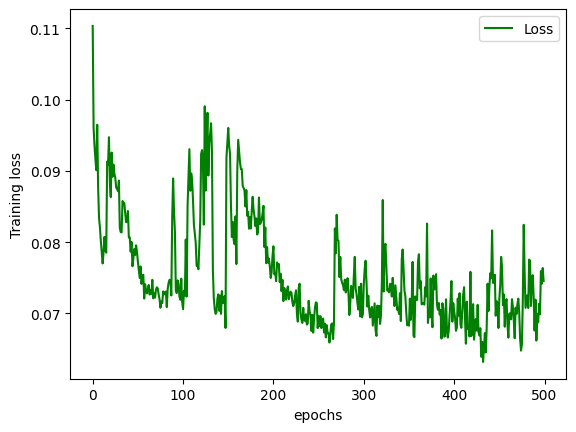

In [ ]:
iterations = 500
BatchSize = 1000
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

trainLoss = []

for epoch in range(iterations):
  runningLoss = 0
  
  for i in range(int(TrainImages.size()[0]/BatchSize)):
    inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize).long()).double()
    labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize).long()).double()

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    runningLoss +=loss.item()
    #runningAcc += (outputs == labels).item().sum()
  
  trainLoss.append(runningLoss/(TrainImages.size()[0]/Batchsize))
  #trainAcc.append(runningAcc/(TrainImages.size()[0]/Batchsize))
  if epoch%50 == 0:
    print('At Iteration: %d / %d  ;  Training Loss: %f '%(epoch + 1,iterations,runningLoss/(TrainImages.size()[0]/BatchSize)))

print('Training finished')

fig = plt.figure()
plt.plot(range(epoch+1), trainLoss, 'g-', label='Loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('Training loss')
plt.savefig('BCEloss.png')

In [ ]:
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

0.0.weight 	 torch.Size([81, 243])
0.0.bias 	 torch.Size([81])
0.2.weight 	 torch.Size([81, 81])
0.2.bias 	 torch.Size([81])
classifier.0.weight 	 torch.Size([81, 81])
classifier.0.bias 	 torch.Size([81])


**Saving the model**

In [ ]:
torch.save(net.state_dict(), '/content/gdrive/MyDrive/Minor_Project_Forest_Fire/Akash/torchmodel9x95k')

**Testing phase**

In [ ]:
def img_transfer(img, imgLabel, bh, bw, no_of_patch):
  
  h = img.shape[0]
  w = img.shape[1]
  c = img.shape[2]
  imgArr = np.empty((no_of_patch, bh*bw*3))
  labelArr = np.empty((no_of_patch, bh*bw*1))

  for i in range(no_of_patch):
    ih = random.randint(0, h-bh)
    iw = random.randint(0, w-bw)
    iArrI = img[ih: ih+bh, iw: iw+bw, :]
    iArrL = img[ih: ih+bh, iw: iw+bw, :]

    for ci in range(c):
      for bhi in range(bh):
        for bwi in range(bw):
          imgArr[i][ci*bh*bw + bhi*bw + bwi] = iArrI[bhi][bwi][ci]
          if ci==0:
            labelArr[i][ci*bh*bw + bhi*bw + bwi] = iArrL[bhi][bwi][ci]
  
  return imgArr, labelArr

In [ ]:
#patch details
patchH = 5
patchW = 5
PatchperImage = 10000

In [ ]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


In [ ]:
#Autoencoder class

class autoencoder(nn.Module):
  def __init__(self):
    super(autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(patchH*patchW*3, patchH*patchW), 
        nn.Tanh(),
        nn.Linear(patchH*patchW, patchH*patchW),
        nn.Tanh())
    
    self.decoder = nn.Sequential(
        nn.Linear(patchH*patchW, patchH*patchW),
        nn.Tanh(), 
        nn.Linear(patchH*patchW, patchH*patchW*3), 
        nn.Sigmoid())
  
  def forward(self, x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x

net = autoencoder()
print(net)

net = net.double().to(device)

init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=75, out_features=25, bias=True)
    (1): Tanh()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=25, bias=True)
    (1): Tanh()
    (2): Linear(in_features=25, out_features=75, bias=True)
    (3): Sigmoid()
  )
)


In [ ]:
#The pixel classifier....segmentation autoencoder

classifier = nn.Sequential(*list(net.children())[:-1])
net = classifier

net.add_module('classifier', nn.Sequential(nn.Linear(patchH*patchW, patchH*patchW), nn.Sigmoid()))
print(net)

net = net.double().to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=75, out_features=25, bias=True)
    (1): Tanh()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=25, out_features=25, bias=True)
    (1): Sigmoid()
  )
)


Loading saved model

In [ ]:
#model = TheModelClass(*args, **kwargs)
net.load_state_dict(torch.load('/content/gdrive/MyDrive/Akash/torchmodel5x5'))
net.eval()

Sequential(
  (0): Sequential(
    (0): Linear(in_features=75, out_features=25, bias=True)
    (1): Tanh()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=25, out_features=25, bias=True)
    (1): Sigmoid()
  )
)

Testing

In [ ]:
TestDatapath = '/content/gdrive/MyDrive/Akash/CorsicanDB/training/rgb/'  # Test Image Data Path
TestLabelpath = '/content/gdrive/MyDrive/Akash/CorsicanDB/training/gt/'  # Test Image Manual Label

In [ ]:
# Load Images and Convert Images into numpy array

imD = Image.open(TestDatapath + '441_rgb.png') #496
imD = imD.resize((256,256))
imD = np.array(imD) 
imD = imD/255.0
    
imL = Image.open(TestLabelpath + '441_gt.png')
imL = imL.resize((256,256))
imL = np.array(imL)
imL = imL/255.0

In [ ]:
imD.shape #image shape

(256, 256, 3)

In [ ]:
imL.shape  #groundtruth shape

(256, 256)

In [ ]:
# Break the image into 10 x 10 patches and push the patches into the network for vessel detection

TestArr = np.zeros(patchH*patchW*3)
imout = np.zeros((imD.shape[0],imD.shape[1]))

for i in range(int(imD.shape[0]/patchH)):
    for j in range(int(imD.shape[1]/patchW)):
        for l1 in range(3):
            for l2 in range(patchH):
                for l3 in range(patchW):
                    TestArr[l1*patchH*patchW + l2*patchW + l3] = imD[i*patchH +l2][j*patchW+l3][l1]
        TestTensor = torch.from_numpy(TestArr)
        out = net(TestTensor.double().to(device))
        if device == "cuda":
            outArr = out.data.cpu()            
        outArr = outArr.numpy()
        for l2 in range(patchH):
            for l3 in range(patchW):
                imout[i*patchH +l2][j*patchW+l3] = outArr[l2*patchW + l3] 

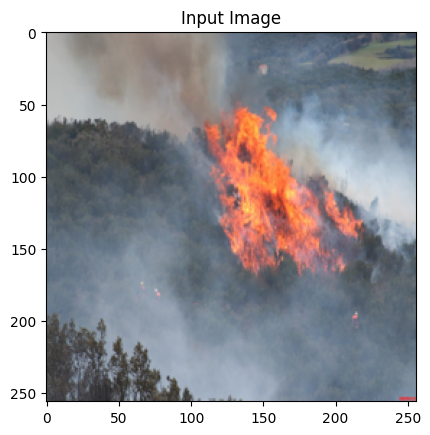

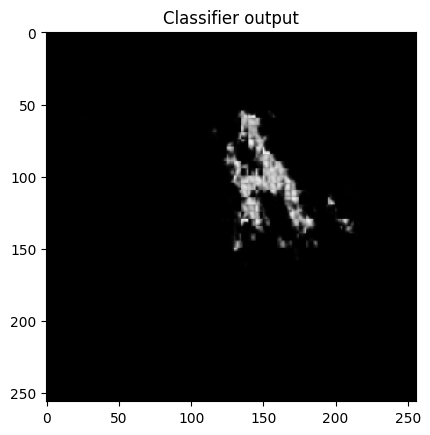

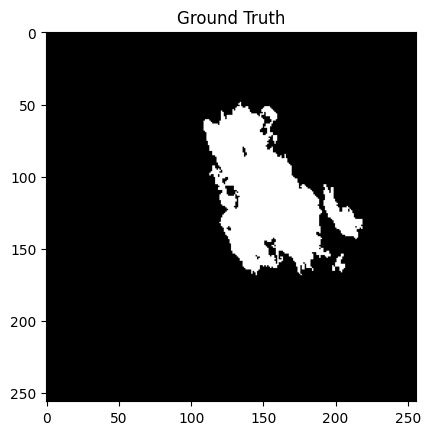

In [ ]:
# Display results

plt.figure()
plt.title('Input Image')
plt.imshow(imD)
plt.savefig('original.png', bbox_inches='tight')

plt.figure()
plt.title('Classifier output')
plt.imshow(imout,'gray')
plt.savefig('segmentation.png', bbox_inches='tight')

plt.figure()
plt.title('Ground Truth')
plt.imshow(imL, 'gray')
plt.savefig('groundtruth.png', bbox_inches='tight')

In [ ]:
imout.shape #predicted mask shape

(256, 256)

In [ ]:
imL.shape  #ground truth label

(256, 256)

In [ ]:
imout

array([[4.66273262e-05, 3.48014577e-05, 4.89645208e-05, ...,
        2.63357905e-05, 3.07153286e-05, 0.00000000e+00],
       [2.78559011e-05, 2.07487438e-05, 2.77910757e-05, ...,
        9.06350328e-06, 8.74004522e-06, 0.00000000e+00],
       [3.70336404e-05, 2.79255326e-05, 2.96535027e-05, ...,
        9.91158625e-06, 8.84780482e-06, 0.00000000e+00],
       ...,
       [3.51236502e-05, 1.91881357e-05, 1.80562110e-05, ...,
        1.06805832e-04, 7.81831566e-05, 0.00000000e+00],
       [5.32744721e-05, 2.35692309e-05, 2.21548181e-05, ...,
        6.79827818e-04, 4.74761762e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
imL

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
imL.max()

0.00392156862745098

In [ ]:
imout.max()

0.9405070284349233

Binarizing GT

In [ ]:
alpha = 0.5
thresh = alpha * np.max(imL)  #setting a threshold

# Binarizing mask
imL_bin = np.uint8(imL)
imL_bin[np.where(imL < thresh)] = 0
imL_bin[np.where(imL >= thresh)] = 1

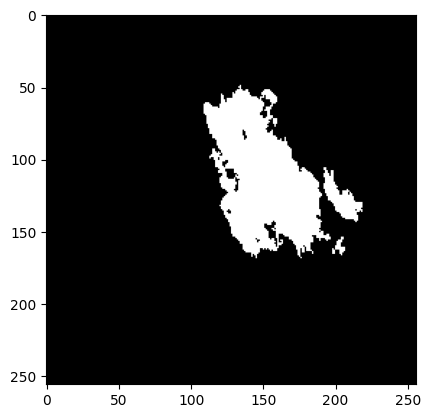

In [ ]:
plt.imshow(imL_bin,'gray')  #plotting the binary mask

Binarizing predicted

In [ ]:
alpha = 0.04
thresh = alpha * np.max(imout)

# Binarizing mask
im_bin = np.uint8(imout)
im_bin[np.where(imout < thresh)] = 0
im_bin[np.where(imout >= thresh)] = 1

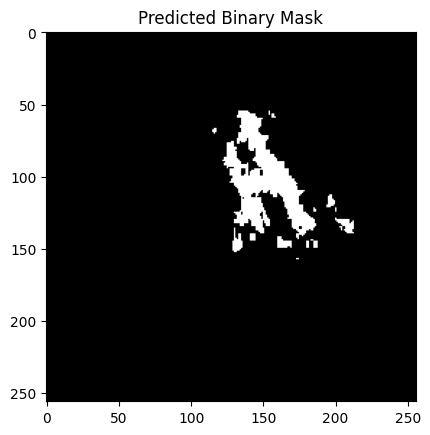

In [ ]:
plt.figure()
plt.title('Predicted Binary Mask')
plt.imshow(im_bin,'gray')
plt.savefig('binary_seg.png',bbox_inches='tight')

Dilation using Gaussian filter

In [ ]:
#Dilation
from skimage.morphology import dilation

gaussian = (1/16)*np.array([[1,2,1],   # gaussian filter for dilation
                  [2,4,2],
                  [1,2,1]])

def multi_dilation(image, kernel, iterations):  # dilation function
    for i in range(iterations):
        image = dilation(image, kernel)
    return image

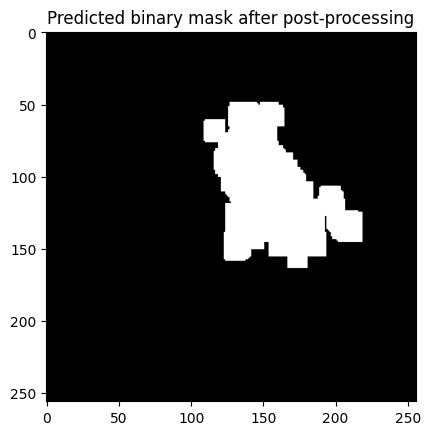

In [ ]:
img = im_bin
dilated = multi_dilation(img, gaussian, 6)
plt.figure()
plt.title('Predicted binary mask after post-processing')
plt.imshow(dilated, cmap = 'gray')
plt.savefig('dilated.png', bbox_inches='tight')

In [ ]:
from google.colab import files

files.download('original.png')
files.download('segmentation.png')
files.download('groundtruth.png')
files.download('binary_seg.png')
files.download('dilated.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IoU using AND/OR operation

In [ ]:
overlap = dilated * imL_bin  # Logical AND
union = (dilated + imL_bin)>0  # Logical OR
iou = overlap.sum() / float(union.sum())
iou

0.7304054929395

To calculate IoU over a number of images

In [ ]:
pred = []

In [ ]:
pred.append(dilated)

In [ ]:
predicted = (pred[0] + pred[1] + pred[2])>0

In [ ]:
overlap = predicted * imL_bin  # Logical AND
union = (predicted + imL_bin)>0  # Logical OR
iou = overlap.sum() / float(union.sum())
iou

0.7523570081709616

In [ ]:
IoU = []

In [ ]:
IoU.append(iou)

In [ ]:
IoU = np.array(IoU)

In [ ]:
IoU

array([0.75235701, 0.76742027, 0.75846677, 0.760454  , 0.70113606,
       0.67285089, 0.82945313])

In [ ]:
print('mIoU = ',np.mean(IoU))

mIoU =  0.7488768762973796


mIoU using keras

In [ ]:
from keras.metrics import MeanIoU
#mask=cv2.imread('/content/gdrive/MyDrive/fire1/Training-20230123T063554Z-001/iou/mask/binarycam'+str(i)+'.png')
#gt=cv2.imread('/content/gdrive/MyDrive/fire1/Training-20230123T063554Z-001/iou/gt/binarygt'+str(i)+'.png')
    
num_classes = 2
IOU_keras = MeanIoU(num_classes=num_classes)  
IOU_keras.update_state(dilated, imL_bin)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8796077


Jaccard score or IoU using sklearn metrics

In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score

y_true = np.array([[0, 1, 1],
                   [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                   [1, 0, 0]])

labels = [0, 1]
jaccards = []
for label in labels:
  jaccard = jaccard_score(dilated.flatten(),imL_bin.flatten(), pos_label=label)
  jaccards.append(jaccard)
  print(jaccard)
 
print(f'avg={np.mean(jaccards)}')

0.9750540855383591
0.7841612670986321
avg=0.8796076763184957


In [ ]:
imou=imout*255

In [ ]:
thresh = 5

im_bool = imou > thresh
im_bool

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
maxval = 1
thresh = 5
im_bin1 = (imou > thresh) * 1
print(im_bin1)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


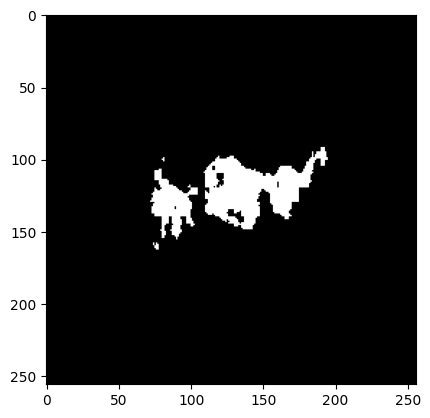

In [ ]:
plt.imshow(im_bin1,'gray')
plt.savefig('segmentation.png')

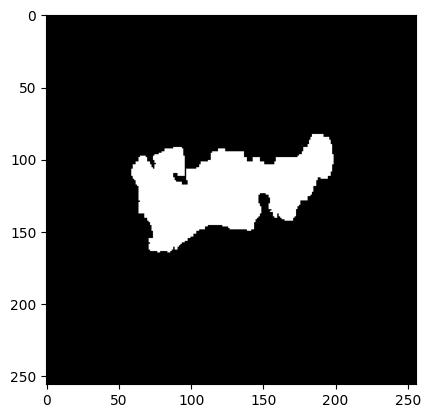

In [ ]:
plt.imshow(imL,'gray')

In [ ]:
im_bin1.max()

1

In [ ]:
files.download('original.png')
files.download('segmentation.png')
files.download('groundtruth.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from skimage.morphology import erosion, dilation

In [ ]:
gaussian = (1/16)*np.array([[1,2,1],   # gaussian filter for dilation
                  [2,4,2],
                  [1,2,1]])

In [ ]:
def multi_dilation(image, kernel, iterations):
    for i in range(iterations):
        image = dilation(image, kernel)
    return image

In [ ]:
img1 = im_bin1

In [ ]:
dilated1 = multi_dilation(img1, gaussian, 4)

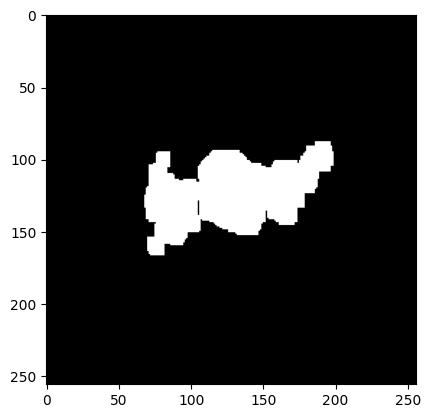

In [ ]:
plt.imshow(dilated1, cmap = 'gray')
#plt.savefig('dilation.png')

In [ ]:
overlap = dilated1 * imL_bin  # Logical AND
union = (dilated1 + imL_bin)>0  # Logical OR
iou = overlap.sum() / float(union.sum())
iou

0.793832861611798

In [ ]:
from keras.metrics import MeanIoU
#mask=cv2.imread('/content/gdrive/MyDrive/fire1/Training-20230123T063554Z-001/iou/mask/binarycam'+str(i)+'.png')
#gt=cv2.imread('/content/gdrive/MyDrive/fire1/Training-20230123T063554Z-001/iou/gt/binarygt'+str(i)+'.png')
    
num_classes = 2
IOU_keras = MeanIoU(num_classes=num_classes)  
IOU_keras.update_state(dilated1, imL_bin)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8854227


In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score

y_true = np.array([[0, 1, 1],
                   [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                   [1, 0, 0]])

labels = [0, 1]
jaccards = []
for label in labels:
  jaccard = jaccard_score(dilated1.flatten(),imL_bin.flatten(), pos_label=label)
  jaccards.append(jaccard)
  print(jaccard)
 
print(f'avg={np.mean(jaccards)}')

0.9770126397262777
0.793832861611798
avg=0.8854227506690379


In [ ]:
for label in labels:
  jaccard = jaccard_score(dilated1.flatten(),imL_bin.flatten(), pos_label=label)
  jaccards.append(jaccard)
  print(jaccard)

0.9770126397262777
0.793832861611798
